In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

#tf.debugging.set_log_device_placement(False)

2.10.1
Num GPUs Available:  1


True

ESTE ES EL BUENO

In [2]:
image_dir ="/Users/jazhi/Desktop/New_HMF_ANN/GDL/VAE_NBody/Projections_axis_off/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/Users/jazhi/Desktop/New_HMF_ANN/GDL/VAE_NBody/Projections_axis_off/D18_x_axis_off_Projection_x_density_density.png',
 '/Users/jazhi/Desktop/New_HMF_ANN/GDL/VAE_NBody/Projections_axis_off/D18_y_axis_off_Projection_y_density_density.png']

In [3]:
# preprocess
image_size = 128

## tf.io is an api for image processing



#TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in
#support.

#It provides useful extra Dataset, streaming, and file system extensions, and is maintained by TensorFlow SIG-IO.

#### add a tf.crop in order to resize and add the 3 color channels


def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.image.random_crop(image,  size=[128,128,4])
    image = tf.reshape(image, shape = (image_size, image_size, 4,))
    image=image[:,:,:3]
    return image

In [4]:
batch_size = 10

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [5]:


len(training_dataset)



8

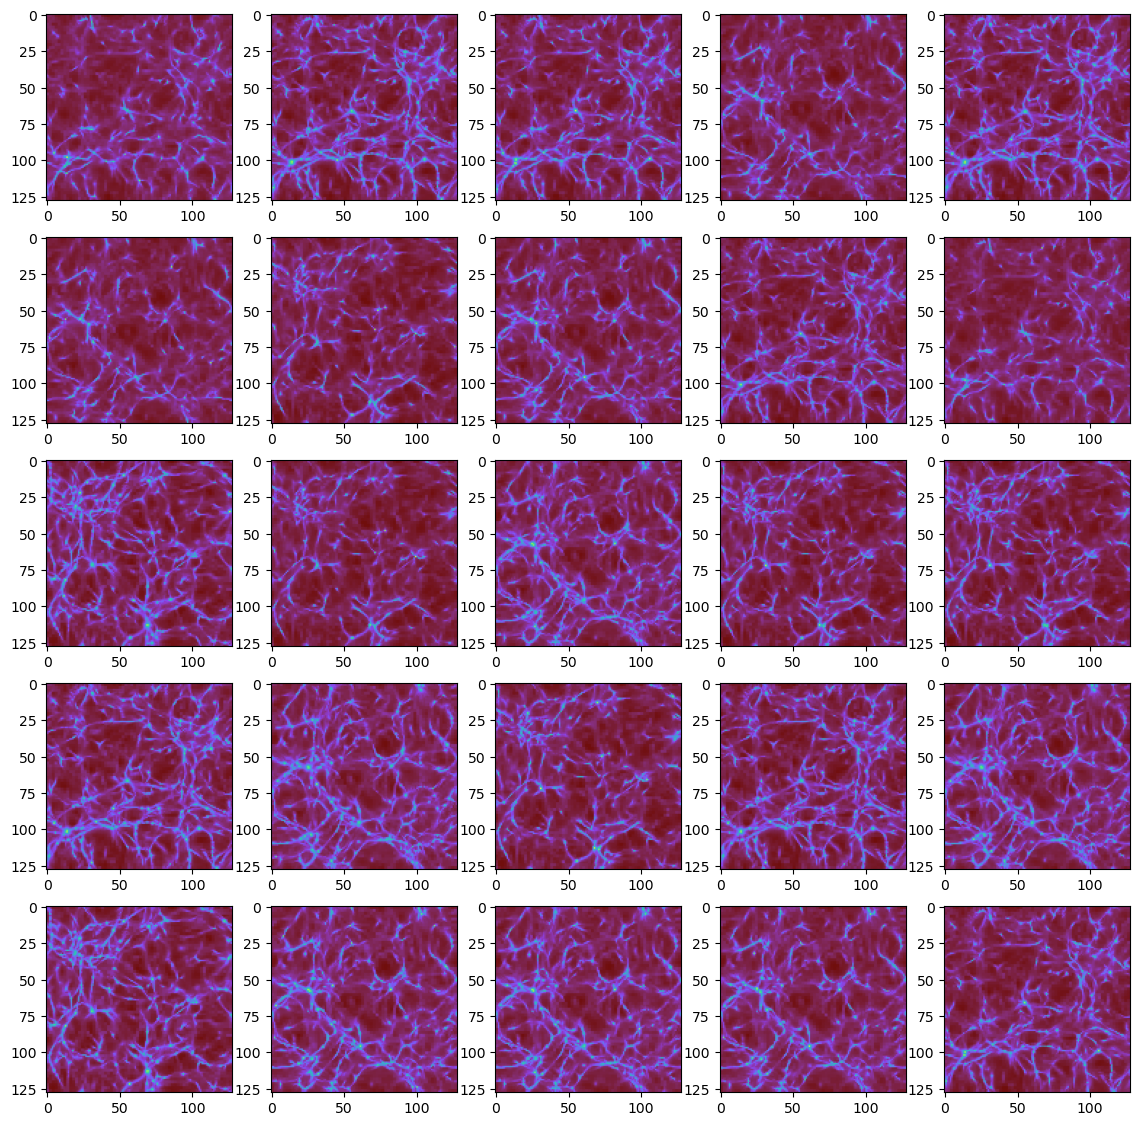

In [6]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [7]:


# build the model

latent_dim = 128



In [8]:


from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
#from keras.layers.advanced_activations import LeakyReLU

from keras.layers.activation import LeakyReLU

from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K



In [9]:


K.clear_session()




In [10]:
### Define the model



encoder_input = Input(shape = (128,128,3)) ### 3 channels one for each color


###convolutional layer adds convolution filters matrices to images
#### Stride is a parameter of the neural network's filter that modifies the amount of movement
###over the image or video.  For example, if a neural network's stride is set to 1,
#the filter will move one pixel, or unit,  at a time
#the kernel size refers to how mani pixels will have the convolutional filter kernel, in this case
### kernel size = 5means a 25 total pixel amount filter is applied

### Padding refers to  it refers to the amount of pixels added to an image 
#when it is being processed by the kernel of a CNN.
#For example, if the padding in a CNN is set to zero,
#then every pixel value that is added will be of value zero. 
#If, however, the zero padding is set to 1, 
##there will be a one pixel border added to the image with a pixel value of zero.


## batch normalization  normalization of the layers' inputs by re-centering and re-scaling.
### prevents some layers exploding (gradient explosion)

x = Conv2D(32, kernel_size=3, activation = 'relu', strides = 2, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128]
for i in filter_size:
    x = Conv2D(i, kernel_size=3, activation = 'relu', strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [11]:
# build the decoder

### the decoder essentially has to deconvolute all convolutional layers
### that's why we see a lot of selu activation functions as well as transposed convolution layers

decoder = Sequential()
decoder.add(Dense(256, activation = 'relu', input_shape = (latent_dim, )))
decoder.add(BatchNormalization())
decoder.add(Reshape((1,1,256)))

#decoder.add(Dense(128, activation = 'relu'))
#decoder.add(Reshape((3,3,256)))

decoder.add(Conv2DTranspose(256, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(256, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (3,3), activation = 'relu', strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (3,3), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 256)        590080    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 2, 2, 256)        1024      
 hNormalization)                                                 
                                                        

In [12]:
### Put Kullback Leiber divergence definition somewhere

# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var)) ## original loss =  -0.5
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (128*128)) * kl_loss(mu, log_var)



In [13]:


# conmbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()



Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 128),        8549824     ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 3)  1790607     ['encoder[0][2]']              

In [14]:


# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "/Users/jazhi/Desktop/New_HMF_ANN/GDL/VAE_NBody/outputs/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()



In [15]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss ###original = 0.001 *kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 5 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))


1/1 [==============================] - 6s 6s/step
Epoch:  1
1/1 [==============================] - 0s 24ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.056767214 - KL loss: 0.00074936665
Epoch: 1 - Step: 1 - MSE loss: 0.057021387 - KL loss: 9.887612e-05
Epoch: 1 - Step: 2 - MSE loss: 0.054313798 - KL loss: 3.6586727e-05
Epoch: 1 - Step: 3 - MSE loss: 0.05379086 - KL loss: 1.570643e-05
Epoch: 1 - Step: 4 - MSE loss: 0.052039362 - KL loss: 8.738227e-06
1/1 [==============================] - 0s 24ms/step
Epoch: 1 - Step: 5 - MSE loss: 0.050668225 - KL loss: 6.0602556e-06
Epoch: 1 - Step: 6 - MSE loss: 0.04903052 - KL loss: 4.2180995e-06
Epoch: 1 - Step: 7 - MSE loss: 0.047045182 - KL loss: 2.9687653e-06
Epoch:  2
1/1 [==============================] - 0s 20ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.043735214 - KL loss: 2.3155706e-06
Epoch: 2 - Step: 1 - MSE loss: 0.039129455 - KL loss: 3.2976036e-06
Epoch: 2 - Step: 2 - MSE loss: 0.0321263 - KL loss: 1.0758406e-05
Epoch: 2 - Step: 3 - MSE loss: 0.

1/1 [==============================] - 0s 20ms/step
Epoch: 13 - Step: 5 - MSE loss: 0.020159457 - KL loss: 0.0005517554
Epoch: 13 - Step: 6 - MSE loss: 0.0189736 - KL loss: 0.00012839965
Epoch: 13 - Step: 7 - MSE loss: 0.017250357 - KL loss: 0.00018616256
Epoch:  14
1/1 [==============================] - 0s 20ms/step
Epoch: 14 - Step: 0 - MSE loss: 0.019305823 - KL loss: 0.00013529761
Epoch: 14 - Step: 1 - MSE loss: 0.019349486 - KL loss: 0.00012235998
Epoch: 14 - Step: 2 - MSE loss: 0.019571215 - KL loss: 0.00014496289
Epoch: 14 - Step: 3 - MSE loss: 0.018207436 - KL loss: 0.0002722295
Epoch: 14 - Step: 4 - MSE loss: 0.018816154 - KL loss: 0.00028689796
1/1 [==============================] - 0s 20ms/step
Epoch: 14 - Step: 5 - MSE loss: 0.019413956 - KL loss: 0.00025924676
Epoch: 14 - Step: 6 - MSE loss: 0.018881816 - KL loss: 0.00021634065
Epoch: 14 - Step: 7 - MSE loss: 0.018029226 - KL loss: 0.0004886491
Epoch:  15
1/1 [==============================] - 0s 25ms/step
Epoch: 15 - Step

1/1 [==============================] - 0s 16ms/step
Epoch: 26 - Step: 0 - MSE loss: 0.017217625 - KL loss: 0.0003658394
Epoch: 26 - Step: 1 - MSE loss: 0.017676508 - KL loss: 0.00021414513
Epoch: 26 - Step: 2 - MSE loss: 0.01834235 - KL loss: 0.0002927805
Epoch: 26 - Step: 3 - MSE loss: 0.017243247 - KL loss: 0.00042388943
Epoch: 26 - Step: 4 - MSE loss: 0.017048724 - KL loss: 0.00055203633
1/1 [==============================] - 0s 16ms/step
Epoch: 26 - Step: 5 - MSE loss: 0.017319473 - KL loss: 0.000544327
Epoch: 26 - Step: 6 - MSE loss: 0.01864043 - KL loss: 0.0003652858
Epoch: 26 - Step: 7 - MSE loss: 0.01679714 - KL loss: 0.0011716785
Epoch:  27
1/1 [==============================] - 0s 47ms/step
Epoch: 27 - Step: 0 - MSE loss: 0.019252105 - KL loss: 0.00075480604
Epoch: 27 - Step: 1 - MSE loss: 0.016947372 - KL loss: 0.00012669018
Epoch: 27 - Step: 2 - MSE loss: 0.018945547 - KL loss: 8.8621025e-05
Epoch: 27 - Step: 3 - MSE loss: 0.017553894 - KL loss: 0.0002137814
Epoch: 27 - Ste

1/1 [==============================] - 0s 31ms/step
Epoch: 38 - Step: 5 - MSE loss: 0.017167967 - KL loss: 0.005004927
Epoch: 38 - Step: 6 - MSE loss: 0.017895095 - KL loss: 0.0011938524
Epoch: 38 - Step: 7 - MSE loss: 0.01693253 - KL loss: 0.0036996726
Epoch:  39
1/1 [==============================] - 0s 47ms/step
Epoch: 39 - Step: 0 - MSE loss: 0.016878087 - KL loss: 0.0056590987
Epoch: 39 - Step: 1 - MSE loss: 0.017271854 - KL loss: 0.007884547
Epoch: 39 - Step: 2 - MSE loss: 0.017122393 - KL loss: 0.0042239535
Epoch: 39 - Step: 3 - MSE loss: 0.017393785 - KL loss: 0.005389486
Epoch: 39 - Step: 4 - MSE loss: 0.016907755 - KL loss: 0.009578701
1/1 [==============================] - 0s 16ms/step
Epoch: 39 - Step: 5 - MSE loss: 0.0159988 - KL loss: 0.0026653954
Epoch: 39 - Step: 6 - MSE loss: 0.017281597 - KL loss: 0.0020408868
Epoch: 39 - Step: 7 - MSE loss: 0.017409189 - KL loss: 0.0037750863
Epoch:  40
1/1 [==============================] - 0s 16ms/step
Epoch: 40 - Step: 0 - MSE los

Epoch: 51 - Step: 2 - MSE loss: 0.016098594 - KL loss: 0.040473096
Epoch: 51 - Step: 3 - MSE loss: 0.013530222 - KL loss: 0.07750527
Epoch: 51 - Step: 4 - MSE loss: 0.014869762 - KL loss: 0.0346305
1/1 [==============================] - 0s 110ms/step
Epoch: 51 - Step: 5 - MSE loss: 0.013454254 - KL loss: 0.09062058
Epoch: 51 - Step: 6 - MSE loss: 0.01712604 - KL loss: 0.01795165
Epoch: 51 - Step: 7 - MSE loss: 0.017491642 - KL loss: 0.07404794
Epoch:  52
1/1 [==============================] - 0s 47ms/step
Epoch: 52 - Step: 0 - MSE loss: 0.011259998 - KL loss: 0.23251529
Epoch: 52 - Step: 1 - MSE loss: 0.014016411 - KL loss: 0.044272713
Epoch: 52 - Step: 2 - MSE loss: 0.016360536 - KL loss: 0.035279702
Epoch: 52 - Step: 3 - MSE loss: 0.014164052 - KL loss: 0.06567599
Epoch: 52 - Step: 4 - MSE loss: 0.0128191905 - KL loss: 0.063773386
1/1 [==============================] - 0s 47ms/step
Epoch: 52 - Step: 5 - MSE loss: 0.013111972 - KL loss: 0.038835365
Epoch: 52 - Step: 6 - MSE loss: 0.01

1/1 [==============================] - 0s 31ms/step
Epoch: 64 - Step: 0 - MSE loss: 0.006378008 - KL loss: 0.07400825
Epoch: 64 - Step: 1 - MSE loss: 0.009681237 - KL loss: 0.036029745
Epoch: 64 - Step: 2 - MSE loss: 0.008765505 - KL loss: 0.34188136
Epoch: 64 - Step: 3 - MSE loss: 0.005811875 - KL loss: 0.39155662
Epoch: 64 - Step: 4 - MSE loss: 0.0063805724 - KL loss: 0.21418448
1/1 [==============================] - 0s 94ms/step
Epoch: 64 - Step: 5 - MSE loss: 0.005957143 - KL loss: 0.14062944
Epoch: 64 - Step: 6 - MSE loss: 0.0058262455 - KL loss: 0.104877934
Epoch: 64 - Step: 7 - MSE loss: 0.0047359453 - KL loss: 0.11768708
Epoch:  65
1/1 [==============================] - 0s 47ms/step
Epoch: 65 - Step: 0 - MSE loss: 0.011471406 - KL loss: 0.040184896
Epoch: 65 - Step: 1 - MSE loss: 0.005692327 - KL loss: 0.28285795
Epoch: 65 - Step: 2 - MSE loss: 0.0054645026 - KL loss: 0.27249518
Epoch: 65 - Step: 3 - MSE loss: 0.0051414114 - KL loss: 0.21609457
Epoch: 65 - Step: 4 - MSE loss: 0

1/1 [==============================] - 0s 31ms/step
Epoch: 76 - Step: 5 - MSE loss: 0.0052134423 - KL loss: 0.13517207
Epoch: 76 - Step: 6 - MSE loss: 0.0051837307 - KL loss: 0.21801262
Epoch: 76 - Step: 7 - MSE loss: 0.0058759805 - KL loss: 0.14149907
Epoch:  77
1/1 [==============================] - 0s 125ms/step
Epoch: 77 - Step: 0 - MSE loss: 0.0056956513 - KL loss: 0.1378245
Epoch: 77 - Step: 1 - MSE loss: 0.0052768076 - KL loss: 0.08913053
Epoch: 77 - Step: 2 - MSE loss: 0.005171734 - KL loss: 0.08524553
Epoch: 77 - Step: 3 - MSE loss: 0.0050597023 - KL loss: 0.06994506
Epoch: 77 - Step: 4 - MSE loss: 0.0050683217 - KL loss: 0.06441216
1/1 [==============================] - 0s 16ms/step
Epoch: 77 - Step: 5 - MSE loss: 0.004711824 - KL loss: 0.07005452
Epoch: 77 - Step: 6 - MSE loss: 0.0047760177 - KL loss: 0.05101489
Epoch: 77 - Step: 7 - MSE loss: 0.0038062949 - KL loss: 0.065038666
Epoch:  78
1/1 [==============================] - 0s 31ms/step
Epoch: 78 - Step: 0 - MSE loss: 0.

Epoch: 89 - Step: 2 - MSE loss: 0.0044276146 - KL loss: 0.08511441
Epoch: 89 - Step: 3 - MSE loss: 0.0053836056 - KL loss: 0.07708111
Epoch: 89 - Step: 4 - MSE loss: 0.004715447 - KL loss: 0.17409042
1/1 [==============================] - 0s 31ms/step
Epoch: 89 - Step: 5 - MSE loss: 0.0047005857 - KL loss: 0.19060487
Epoch: 89 - Step: 6 - MSE loss: 0.0043803034 - KL loss: 0.17370121
Epoch: 89 - Step: 7 - MSE loss: 0.004426311 - KL loss: 0.16211835
Epoch:  90
1/1 [==============================] - 0s 15ms/step
Epoch: 90 - Step: 0 - MSE loss: 0.0036123018 - KL loss: 0.15033029
Epoch: 90 - Step: 1 - MSE loss: 0.0049984804 - KL loss: 0.10713055
Epoch: 90 - Step: 2 - MSE loss: 0.0045567253 - KL loss: 0.12106885
Epoch: 90 - Step: 3 - MSE loss: 0.004866315 - KL loss: 0.093035504
Epoch: 90 - Step: 4 - MSE loss: 0.004474386 - KL loss: 0.08174529
1/1 [==============================] - 0s 47ms/step
Epoch: 90 - Step: 5 - MSE loss: 0.003937711 - KL loss: 0.087119594
Epoch: 90 - Step: 6 - MSE loss: 

In [ ]:
# # visualize output

# import cv2
# output_dir = "/Users/jazhi/Desktop/New_HMF_ANN/GDL/VAE_NBody/"
# files = os.listdir(output_dir)

# for file in files:
#     image = cv2.imread(output_dir + file)
#     cv2.imshow("Output", image)
#     if cv2.waitKey(1) and 0xFF == ord('q'):
#         break

In [ ]:
training_batch.shape

In [ ]:
reconstructed.shape

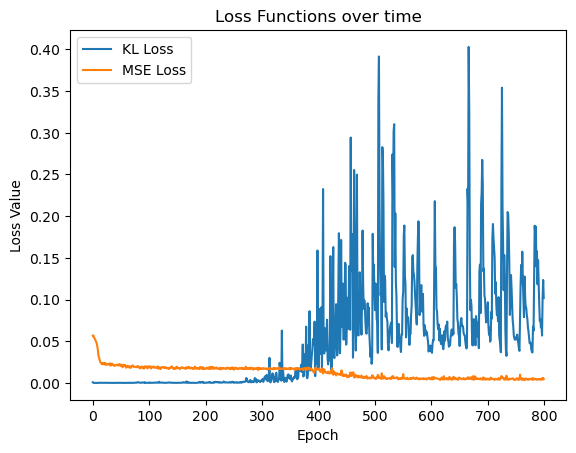

In [16]:
plt.plot(kl_losses, label = 'KL Loss')
plt.xlabel("Epoch")
plt.ylabel("KL Loss")
plt.title("KL Loss over time")
#plt.show()

#plt.plot(kl_losses, label = 'KL Loss')
plt.plot(mse_losses, label = 'MSE Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss Functions over time")
plt.legend()
plt.show()

1/1 [==============================] - 4s 4s/step


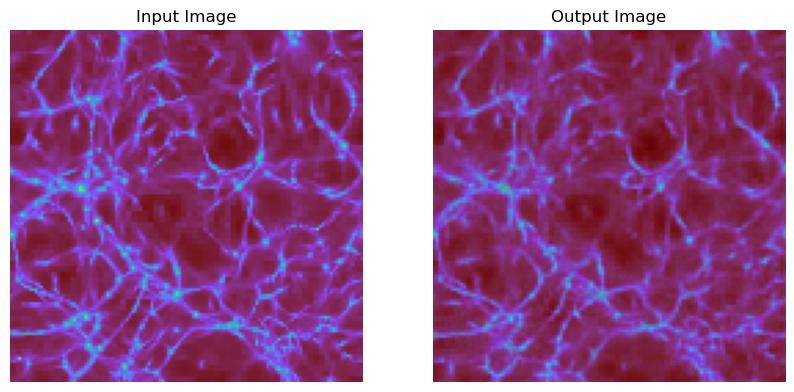

In [17]:
import cv2

# Function to display images
def display_images(images):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(images[0])
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    axes[1].imshow(images[1])
    axes[1].set_title("Output Image")
    axes[1].axis("off")
    plt.show()

# Load and preprocess a sample image
sample_image_path = "/Users/jazhi/Desktop/New_HMF_ANN/GDL/VAE_NBody/Projections_axis_off/D43_z_axis_off_Projection_z_density_density.png"
sample_image = preprocess(sample_image_path)
sample_image = tf.expand_dims(sample_image, axis=0)

# Pass the sample image through the autoencoder
output_image = model.predict(sample_image)

# Convert the images to NumPy arrays
sample_image_np = sample_image[0]
output_image_np = output_image[0]

# Display the images
display_images([sample_image_np, output_image_np])